In [1]:
# autoreload
%reload_ext autoreload
%autoreload 2

## Cleaning coordinates
Create a new column in the df with the 'gold standard' coordinates. These are coordinates in decimal degree format. Save as a csv for export to GEE. Sense-check each point, refine, and transfer final files (as csv and yaml) to Ben H. 

Where coordinates are explicitly available in papers, use these. Where not available, take 'location' and search for coordinates using Google Maps API. 

In [2]:
### imports
# general
import pandas as pd
import re
import googlemaps
from tqdm.auto import tqdm

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

# custom
from calcification import utils, config

/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
### load data
fp = config.data_dir / "Orlando_data.xlsx"
df = utils.process_df(pd.read_excel(fp, sheet_name="all_data"))

# create column and fill with cleaned coordinates, where 
df['loc'] = df['cleaned_coords'].fillna(df['location'])
# df['loc'].value_counts()

Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml.

Duplicate DOIs found, treat with caution:
['10.4319/lo.2014.59.3.1081', '10.1111/gcb.14379', '10.1016/j.jembe.2013.12.013', '10.1007/s00338-016-1425-0', '10.1007/s00227-012-2001-y']


In [4]:
df.columns

Index(['extractor', 'notes', 'secondary_check', 'include', 'authors', 'doi',
       'year', 'species_types', 'taxa', 'location', 'coords', 'cleaned_coords',
       'life_stages', 'pco2', 'pco2_se', 'pco2_sd', 'phnbs', 'phnbs_se',
       'phnbs_sd', 'phtot', 'phtot_se', 'phtot_sd', 'ta', 'ta_se', 'ta_sd',
       'dic', 'dic_se', 'dic_sd', 'omegac', 'omegac_se', 'omegac_sd', 'omegaa',
       'omegaa_se', 'omegaa_sd', 'co3', 'co3_se', 'co3_sd', 'hco3', 'hco3_se',
       'hco3_sd', 'do', 'do_se', 'do_sd', 'irr', 'irr_se', 'irr_sd', 'ipar',
       'ipar_se', 'ipar_sd', 't_in', 't_in_se', 't_in_sd', 's_in', 's_in_se',
       's_in_sd', 'n', 'calcification', 'calcification_se', 'calcification_sd',
       'calcification_units', 'duration', 'methods', 'notes+', 'notes++',
       'unnamed:_64', 'unnamed:_65', 'genus', 'species', 'family',
       'functional_group', 'loc'],
      dtype='object')

In [5]:
coord = df[df.doi == "10.1098/rspb.2018.1168"][['location', 'coords', 'cleaned_coords']].cleaned_coords
coord

6315    16°48'S, 123°04'E
6316    16°48'S, 123°04'E
6317    16°48'S, 123°04'E
6318    16°48'S, 123°04'E
6319    16°40'S, 123°14'E
6320    16°40'S, 123°14'E
6321    16°40'S, 123°14'E
6322    16°40'S, 123°14'E
6323    16°48'S, 123°04'E
6324    16°48'S, 123°04'E
6325    16°48'S, 123°04'E
6326    16°48'S, 123°04'E
6327    16°40'S, 123°14'E
6328    16°40'S, 123°14'E
6329    16°40'S, 123°14'E
6330    16°40'S, 123°14'E
6331    16°48'S, 123°04'E
6332    16°48'S, 123°04'E
6333    16°48'S, 123°04'E
6334    16°48'S, 123°04'E
6335    16°40'S, 123°14'E
6336    16°40'S, 123°14'E
6337    16°40'S, 123°14'E
6338    16°40'S, 123°14'E
Name: cleaned_coords, dtype: object

In [6]:
# TODO: start with this
coord.iloc[0]

"16°48'S, 123°04'E"

In [7]:
utils.standardize_coordinates("16°40' S, 123°14' E")

(-16.666666666666668, 123.23333333333333)

In [8]:
utils.standardize_coordinates(coord.iloc[0])

(-16.8, 123.06666666666666)

In [22]:
utils.get_coordinates_from_gmaps('Paracel islands', gmaps_client)

0    None
1    None
dtype: object

In [9]:
### get locations for which there are no coordinates (from location, where cleaned_coords is NaN)
locs = df.loc[df['cleaned_coords'].isna(), 'location'].unique()
# get coordinates for these locations using Google Maps API
gmaps_coords = {}
GMAPS_API_KEY = utils.read_yaml(config.resources_dir / "api_keys.yaml")['google_maps_api']
gmaps_client = googlemaps.Client(key=GMAPS_API_KEY)

for loc in tqdm(locs, desc="Querying Google Maps to retrieve coordinates of locations"):
    gmaps_coords[loc] = tuple(utils.get_coordinates_from_gmaps(loc, gmaps_client).values)   # slightly hacky formatting since originally written for processing dataframe column
gmaps_coords

Querying Google Maps to retrieve coordinates of locations: 100%|██████████| 104/104 [00:13<00:00,  7.85it/s]


{'Palmyra Atoll': (np.float64(5.8885026), np.float64(-162.0786656)),
 'Fiji, UK aquarium': (np.float64(55.378051), np.float64(-3.435973)),
 'Aquarium': (None, None),
 'Island Point, Panama': (np.float64(8.537981), np.float64(-80.782127)),
 "Mo'orea, French Polynesia": (np.float64(-17.5388435),
  np.float64(-149.8295234)),
 'Gulf of Aqaba, Jordan': (np.float64(28.6929261), np.float64(34.7298765)),
 'Okinawa, Japan': (np.float64(26.3343533), np.float64(127.8056058)),
 'Hawaii, various': (np.float64(19.8986819), np.float64(-155.6658568)),
 'Oku Reef, Okinawa, Japan': (np.float64(26.8271449), np.float64(128.2796738)),
 'Indo-Pacific': (None, None),
 'Key West, Florida Keys': (np.float64(24.5550593), np.float64(-81.7799871)),
 'Florida Bay, Florida Keys': (np.float64(24.9586323),
  np.float64(-80.67985209999999)),
 'Key Biscayne, Florida Keys': (np.float64(25.693713),
  np.float64(-80.1628248)),
 'Florida Keys National Marine Sanctuary': (np.float64(24.4269857),
  np.float64(-83.11127979999

In [21]:
gmaps_coords['Hobihu Reef, Taiwan']

(np.float64(23.69781), np.float64(120.960515))

In [10]:
unique_coords = df['cleaned_coords'].unique()

failed_coords = []
for coord in unique_coords:
    standardised_coord = utils.standardize_coordinates(coord)
    if not standardised_coord:
        failed_coords.append(coord)
    else:
        print('OG:', coord, 'Standardised:', standardised_coord)

OG: 14°41′17.4′′S, 145°28′03.6′′E / 14°41′47.0′′S, 145°27′02.9′′E Standardised: (np.float64(-14.692277777777779), np.float64(145.45923611111112))
OG: 17°28′40.51′′S, 149°50′22.80′′W Standardised: (-17.477919444444442, -149.8396666666667)
OG: 25.02° N, 80.49° W Standardised: (25.02, -80.49)
OG: 26°19.62’N, 80°04.33’W Standardised: (26.327, -80.07216666666666)
OG: nan Standardised: nan
OG: 17.05°N 111.30°E Standardised: (17.05, 111.3)
OG: 23°26′S 151°52′E Standardised: (-23.433333333333334, 151.86666666666667)
OG: 18°12′N, 109°28′E Standardised: (18.2, 109.46666666666667)
OG: 9.3326, -82.2164 Standardised: (9.3326, -82.2164)
OG: 9.22025, -82.3231 Standardised: (9.22025, -82.3231)
OG: 23 33’S, 151 54’E Standardised: (-23.55, 151.9)
OG: 18° 41.126′S, 146° 30.731′E Standardised: (-18.685433333333332, 146.51218333333333)
OG: 24.62055° N, 81.37078° W Standardised: (24.62055, -81.37078)
OG: 21.955°N, 120.766°E / 21.931°N, 120.745°E Standardised: (np.float64(21.942999999999998), np.float64(120.

In [11]:
# fill loc with standardised cleaned_coords if not NaN, otherwise fill with coordinates extracted from location
# df['loc'] = df['cleaned_coords'].apply(lambda x: utils.standardize_coordinates(x) if pd.notna(x) else None).fillna(df['location'].map(gmaps_coords))
df['loc'] = df['cleaned_coords'].apply(lambda x: utils.standardize_coordinates(x) if pd.notna(x) else None)
# For locations where coordinates from cleaned_coords are available, fill them in
# # For remaining locations, use the coordinates from Google Maps API if available
df['loc'] = df['loc'].fillna(df['location'].map(gmaps_coords))

# # Extract latitude and longitude from the coordinate tuples, with proper type checking
df['latitude'] = df['loc'].apply(lambda x: x[0] if isinstance(x, tuple) else None)
df['longitude'] = df['loc'].apply(lambda x: x[1] if isinstance(x, tuple) else None)

In [12]:
### save to yaml, using (uniquified) doi as key, latitude, longitude as values
temp_df = df.copy()
temp_df['location_lower'] = temp_df['location'].str.lower()

# Set index and drop duplicates based on the lowercase columns
locs_df = temp_df.set_index('doi').drop_duplicates(['location_lower', 'cleaned_coords', 'latitude', 'longitude'])[['location', 'latitude', 'longitude']]
locs_df.dropna(subset=['latitude', 'longitude'], inplace=True) # remove empty rows
dois = locs_df.index
# make any duplicated index values unique by appending a letter
locs_df.index = utils.uniquify_repeated_values(dois)
# send to dictionary
locs_dict = locs_df.to_dict(orient='index')
# save dictionary to yaml
utils.write_yaml(locs_dict, config.resources_dir / "locations.yaml")
print(f'Saved locations to {config.resources_dir / "locations.yaml"}')
locs_df.to_csv(config.resources_dir / "locations.csv", index=True, index_label='doi')
print(f'Saved locations to {config.resources_dir / "locations.csv"}')
locs_df

Saved locations to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/locations.yaml
Saved locations to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/locations.csv


,location,latitude,longitude
10.1111/jpy.13290,"Lizard Island, GBR, Australia",-14.692278,145.459236
10.1038/s41598-019-40620-8-LOC-A,"Mo'orea, French Polynesia",-17.477919,-149.839667
10.1038/s41598-019-40620-8-LOC-B,"Key Largo, Florida, US",25.020000,-80.490000
10.3354/meps11591,"Boca Raton, Florida, US",26.327000,-80.072167
10.3354/meps09309,Palmyra Atoll,5.888503,-162.078666
...,...,...,...
10.1130/G30210A.1,Florida,27.664827,-81.515754
10.1098/rspb.2015.1887,"Puerto Morelos, Mexico",20.847808,-86.875534
10.1016/j.ecss.2009.03.038,"Chwaka Bay, Zanzibar",-6.143635,39.465738
10.3354/meps11655,"Broad Key, Florida, US",25.351226,-80.265052


## Visualising

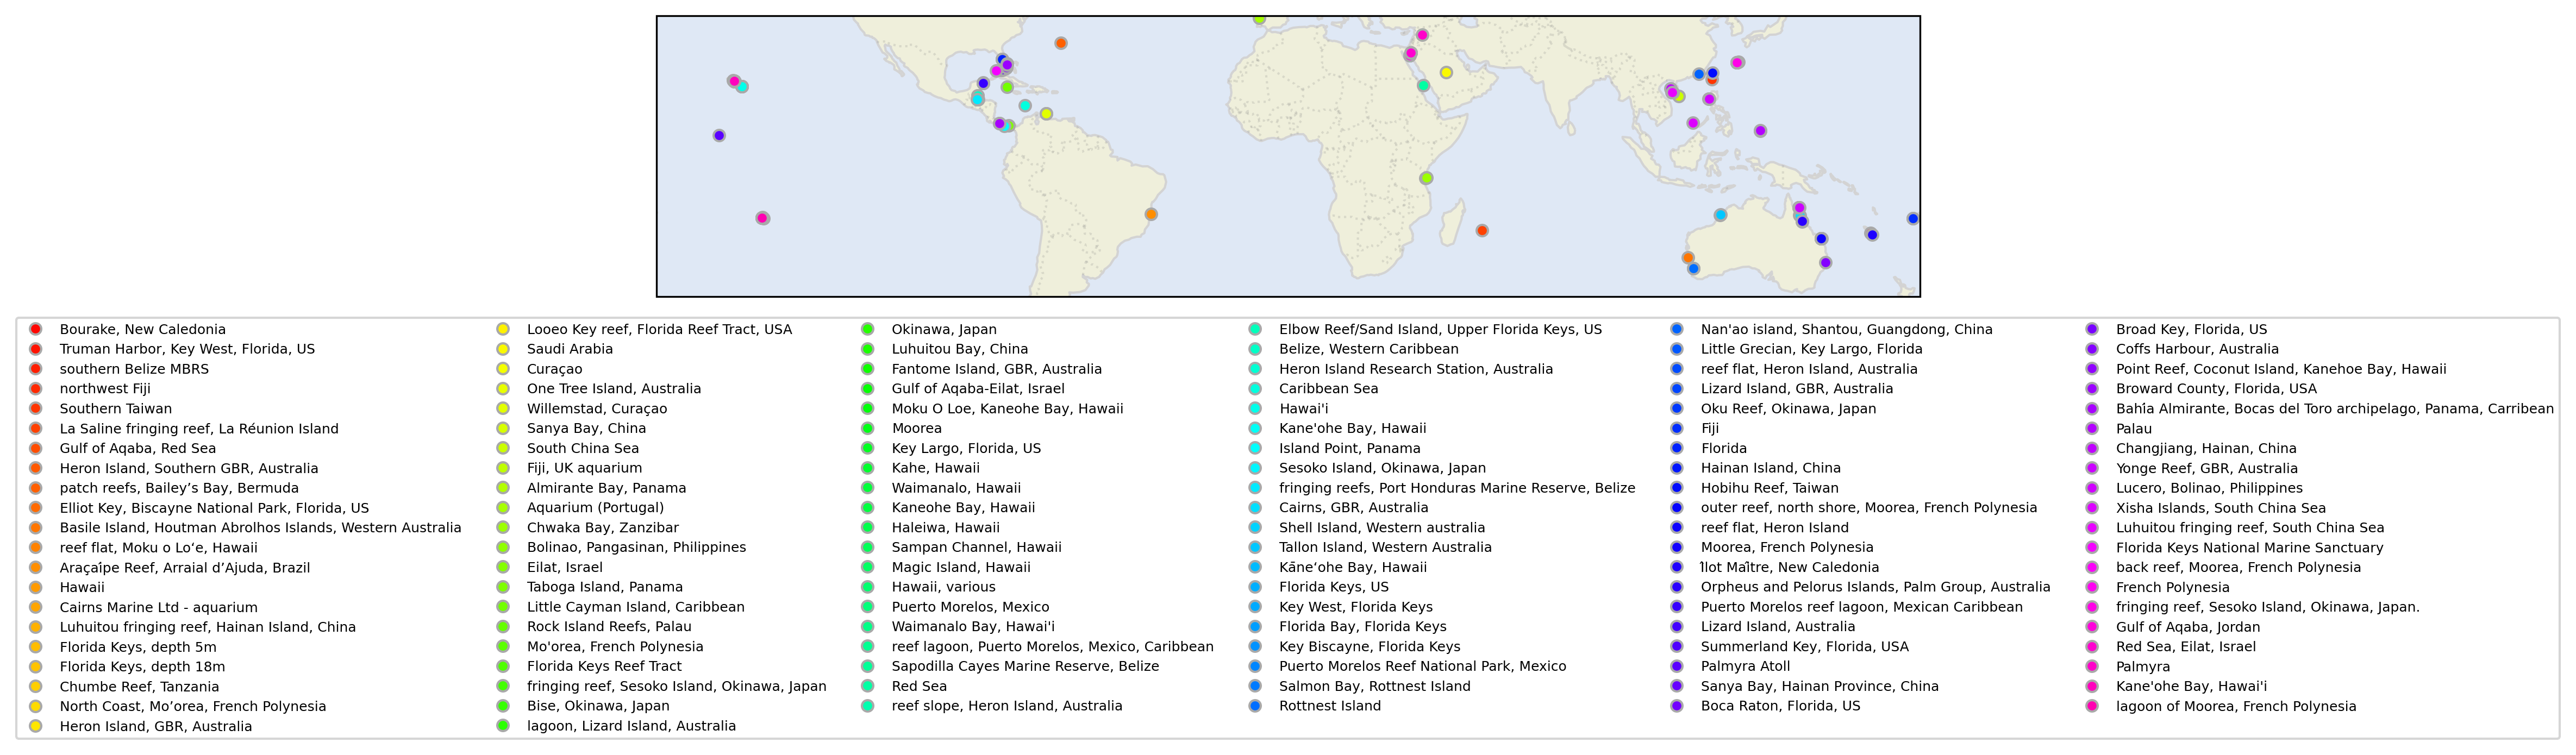

In [13]:
### plot spatial disribution of studies

locs = utils.read_yaml(config.resources_dir / "locations.yaml")   # read locations.yaml
locs_df = pd.DataFrame(locs).T
locs_df = locs_df.dropna()  # drop nans

# create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 20), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
ax.set_extent([-180, 180, -40, 40], crs=ccrs.PlateCarree())

# add features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN, alpha=0.3)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', alpha=0.2)

# add locations with colors
colors = sns.color_palette("hsv", len(locs_df))
locations_to_plot = locs_df.drop_duplicates('location')
for i, (doi, row) in enumerate(locations_to_plot.iterrows()):
    data = locs[doi]
    ax.plot(data["longitude"], data["latitude"], 'o', markeredgecolor='darkgrey', markersize=5, color=colors[i], transform=ccrs.PlateCarree(), label=data["location"])

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -1.6), ncol=len(locs_df)//20, fontsize=6);   # add legend

## Applying reef areas

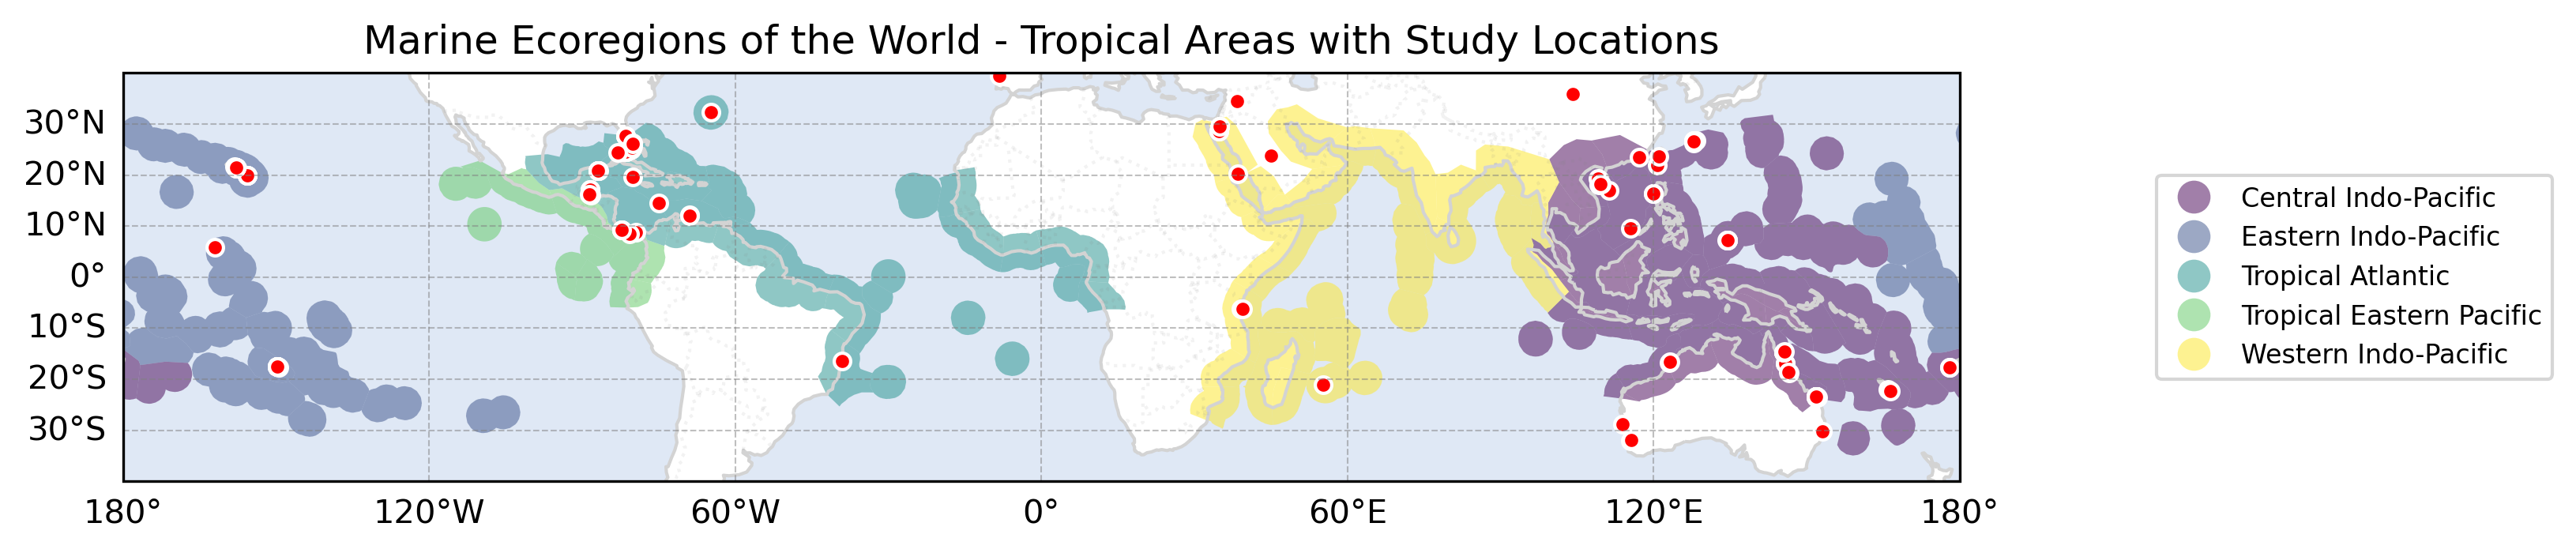

In [15]:
import geopandas as gpd
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
import json

# marine area shapefiles dir
shp_dir_fp = config.climatology_data_dir / "MEOW"

# read in shapefiles from directory
gdf = gpd.read_file(shp_dir_fp / "meow_ecos.shp")
tropical_areas_df = gdf[gdf['Lat_Zone'] == 'Tropical']

fig, ax = plt.subplots(1, 1, figsize=(10, 20), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
ax.set_extent([-180, 180, -40, 40], crs=ccrs.PlateCarree())
# add features
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.OCEAN, alpha=0.3)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', alpha=0.1)

# plot tropical areas on world map
tropical_areas_df.plot(ax=ax, column='REALM', legend=True, 
                       cmap='viridis', alpha=0.5, 
                       legend_kwds={'bbox_to_anchor': (1.1, 0.5), 
                                    'loc': 'center left',
                                    'fontsize': 8})

for i, (doi, data) in enumerate(locs_df.iterrows()):
    # Convert coordinates to float if needed
    lat = float(data["latitude"]) if isinstance(data["latitude"], str) else data["latitude"]
    lon = float(data["longitude"]) if isinstance(data["longitude"], str) else data["longitude"]
    
    # Only plot if coordinates are valid
    if pd.notna(lat) and pd.notna(lon):
        ax.plot(lon, lat, 'o', markeredgecolor='white', markersize=5, 
                color='red', transform=ccrs.PlateCarree())

ax.set_title('Marine Ecoregions of the World - Tropical Areas with Study Locations')

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

In [16]:
### plot spatial distribution of realms

# compute the centroid of each realm by first projecting to a suitable projected CRS
temp_tropical_areas_df = tropical_areas_df.copy()
# Use an equal-area projection to ensure accurate centroid calculation
temp_tropical_areas_df.loc[:,'geometry_projected'] = temp_tropical_areas_df.geometry.to_crs('ESRI:54034')  # World Cylindrical Equal Area
temp_tropical_areas_df.loc[:,'centroid_projected'] = temp_tropical_areas_df['geometry_projected'].centroid
# Convert centroids back to WGS84 (EPSG:4326) for use with lat/lon
temp_tropical_areas_df.loc[:,'centroid'] = temp_tropical_areas_df['centroid_projected'].to_crs('EPSG:4326')
temp_tropical_areas_df.loc[:,'centroid_lat'] = temp_tropical_areas_df['centroid'].y
temp_tropical_areas_df.loc[:,'centroid_lon'] = temp_tropical_areas_df['centroid'].x
# Drop intermediate columns to keep dataframe clean
centroids_df = temp_tropical_areas_df[['RLM_CODE', 'centroid_lat', 'centroid_lon']]
# tropical_areas_df = tropical_areas_df.drop(columns=['geometry_projected', 'centroid_projected'])
# group by realm code and average the lat/lon to get the centroid of each realm
centroids_df = centroids_df.groupby('RLM_CODE').median()

# add column of realm names to centroids df
centroids_df['realm_name'] = centroids_df.index.map(tropical_areas_df.set_index('RLM_CODE')['REALM'].to_dict())


In [17]:
### get the realm for each location in locs_df based on their coordinates
locs_df['latitude'] = pd.to_numeric(locs_df['latitude'], errors='coerce')
locs_df['longitude'] = pd.to_numeric(locs_df['longitude'], errors='coerce')

# create point geometry object from points
points_geometry = [Point(lon, lat) if pd.notna(lon) and pd.notna(lat) else None 
                   for lon, lat in zip(locs_df['longitude'], locs_df['latitude'])]
points_gdf = gpd.GeoDataFrame(locs_df, geometry=points_geometry, crs='EPSG:4326')
# join on geometry
joined = gpd.sjoin(points_gdf, tropical_areas_df[['REALM', 'geometry']], 
                  how='left', predicate='within')

# assign realm to column in locs_df
locs_df['realm'] = joined['REALM']

In [18]:
locations_to_plot = locs_df.copy()

locations_to_plot.loc[:, 'latitude'] = pd.to_numeric(locations_to_plot['latitude'])
locations_to_plot.loc[:, 'longitude'] = pd.to_numeric(locations_to_plot['longitude'])
locations_to_plot.loc[:, 'hover_text'] = list(locations_to_plot.index)

fig = go.Figure()

tropical_geojson = json.loads(tropical_areas_df.to_json())

# add the tropical areas as choropleth layer (second layer)
fig.add_trace(go.Choropleth(
    geojson=tropical_geojson,
    locations=tropical_areas_df.index,
    z=tropical_areas_df.RLM_CODE,  # colour by realm code
    colorscale='Viridis',
    marker_opacity=0.3,
    marker_line_width=0.5,
    marker_line_color='white',
    showscale=False,
    hoverinfo='text',
    name='Tropical Marine Ecoregions'
))
# plot study points on top
for location in locations_to_plot['location'].unique():
    subset = locations_to_plot[locations_to_plot['location'] == location]
    fig.add_trace(go.Scattergeo(
        lon=subset['longitude'],
        lat=subset['latitude'],
        text=subset['hover_text'],
        mode='markers',
        marker=dict(size=12, opacity=0.8),
        hovertemplate='%{text}<br>Latitude: %{lat:.4f}<br>Longitude: %{lon:.4f}',
        name=location
    ))

# label realms
fig.add_trace(go.Scattergeo(
    lon=centroids_df['centroid_lon'],
    lat=centroids_df['centroid_lat'],
    text=centroids_df['realm_name'],
    mode='text',
    textfont=dict(
        size=12,
        color='#2b2b2b'
    ),
    textposition='middle center',
    hoverinfo='none',
    name='Realm Labels'
))

# formatting map view
fig.update_geos(
    lataxis_range=[-40, 40],
    lonaxis_range=[-180, 180],
    showland=True,
    landcolor='lightgray',
    showocean=True,
    oceancolor='aliceblue',
    showcoastlines=True,
    coastlinecolor='darkgray',
    showframe=True,
    showcountries=True,
    countrycolor='whitesmoke',
    projection_type='natural earth',
    resolution=50
)

fig.update_layout(
    title='Spatial Distribution of Studies in Tropical Marine Ecoregions',
    title_x = 0.5,
    title_y = 0.95,
    margin=dict(l=0, r=0, t=30, b=0),
    height=600,
    width=1500,
    showlegend=False
)

fig.show()